# PostgreSQL Queries

In [133]:
import psycopg2
import sys
import pandas as pd
import sqlalchemy
import json
from sqlalchemy import create_engine
import time
import matplotlib as plt
from matplotlib import pyplot as plt


In [134]:
db_username = 'postgres'
db_password = 'postgres'
db_host = 'localhost'
db_port = '5432'
db_name = 'yelp_database'


In [135]:
conn_str = psycopg2.connect(
    host='localhost',
    dbname=db_name,
    user=db_username,
    password=db_password,
    port=5432
)
cursor = conn_str.cursor()

In [136]:
# Plot the graph with execution times
def plot_graph_with_times(execution_times):
    """
    Plots the execution time vs sample size graph.
    """
    # plt.figure(figsize=(10, 6))
    plt.plot(list(execution_times.keys()), list(execution_times.values()), marker="o")
    plt.xscale("log")
    plt.xlabel("Sample Size")
    plt.ylabel("Execution Time (seconds)")
    plt.title("Execution Time vs. Sample Size")
    plt.grid(True)
    plt.show()

In [137]:
import numpy as np
# Print graph

def query_execution_graph(query_function):
  # List of sample sizes (e.g., 100, 1000, 10000, etc.)
  sample_sizes = [10**i for i in range(2, 6)]

  # Dictionary to hold the execution times
  execution_times = {}

  # Establish a PostgreSQL connection
  conn = psycopg2.connect(
      dbname="yelp_database", user="postgres", password="postgres", host="localhost", port="5432"
  )
  cursor = conn.cursor()

  # Loop through each sample size, run the query, and record execution time
  for sample_size in sample_sizes:
        print(f"Running the query for sample size: {sample_size}")
        
        times = []
        for i in range(10):
            start_time = time.time()
            # Run the query for the given sample size
            query = query_function(sample_size)
            cursor.execute(query)
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"Execution time: {execution_time:.2f} seconds")
            times.append(execution_time)

        average_execution_time = np.mean(times)
        # Save the sample size and corresponding execution time into the dictionary
        execution_times[sample_size] = average_execution_time

  # Close the cursor and connection
  cursor.close()
  conn.close()

  # Print the execution times
  print(execution_times)

  # Plot the graph with execution times
  plot_graph_with_times(execution_times)


Testing the query execution time with a sample.

In [138]:
# Run the query for the given sample size
query = f"""
      WITH ranked_business AS (
          SELECT 
              yb.business_id,
              yb.city,
              yb.review_count,
              yb.stars,
              CASE WHEN yb.stars > 4.7 AND yb.review_count > 100
              THEN 1
              ELSE 0
              END AS is_good
          FROM yelp_business yb
      ), concentration_by_city AS (
          SELECT 
              city,
              COUNT(business_id) as num_business,
              SUM(is_good) as total_is_good
          FROM ranked_business
          GROUP BY city
          HAVING COUNT(business_id) > 50
          ORDER BY total_is_good DESC
      )

      SELECT * FROM concentration_by_city LIMIT 10;
      """

start_time = time.time()

cursor.execute(query)

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 0.13 seconds


# Query 1: Top 10 Cities

Top 10 Citites With At Least 50 Businesses with Stars Greater Than 4.7 And Review Count Greater Than 100.

In [139]:
pd.read_sql_query(
    """
    WITH ranked_business AS (
        SELECT 
            yb.business_id,
            yb.city,
            yb.review_count,
            yb.stars,
            CASE WHEN yb.stars > 4.7 AND yb.review_count > 100
            THEN 1
            ELSE 0
            END AS is_good
        FROM yelp_business yb
    ), concentration_by_city AS (
        SELECT 
            city,
            COUNT(business_id) as num_business,
            SUM(is_good) as total_is_good
        FROM ranked_business
        GROUP BY city
        HAVING COUNT(business_id) > 50
        ORDER BY total_is_good DESC
    )

    SELECT * FROM concentration_by_city LIMIT 10;
    """,
    conn_str
    )

/var/folders/73/0ljy4_0j73jf5dbm29fbf7_m0000gn/T/ipykernel_97293/1605633219.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql_query(


,city,num_business,total_is_good
0,Philadelphia,14569,43
1,Tampa,9050,32
2,Santa Barbara,3829,30
3,New Orleans,6209,26
4,Reno,5935,21
5,Indianapolis,7540,19
6,Nashville,6971,18
7,Tucson,9250,9
8,Saint Louis,4827,6
9,Saint Petersburg,1663,6


In [140]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Do not wrap lines
pd.set_option('display.max_colwidth', None)  # Display all contents of each column

print(pd.read_sql_query(
    """
    EXPLAIN ANALYZE
    WITH ranked_business AS (
        SELECT 
            yb.business_id,
            yb.city,
            yb.review_count,
            yb.stars,
            CASE WHEN yb.stars > 4.7 AND yb.review_count > 100
            THEN 1
            ELSE 0
            END AS is_good
        FROM yelp_business yb
    ), concentration_by_city AS (
        SELECT 
            city,
            COUNT(business_id) as num_business,
            SUM(is_good) as total_is_good
        FROM ranked_business
        GROUP BY city
        HAVING COUNT(business_id) > 50
        ORDER BY total_is_good DESC
    )

    SELECT * FROM concentration_by_city LIMIT 10;
    """,
    conn_str
    ))

                                                                                                                                                            QUERY PLAN
0                                                                       Limit  (cost=16457.48..16457.50 rows=10 width=26) (actual time=22.680..22.978 rows=10 loops=1)
1                                                                   ->  Sort  (cost=16457.48..16458.14 rows=265 width=26) (actual time=22.679..22.976 rows=10 loops=1)
2                                                                     Sort Key: (sum(CASE WHEN ((yb.stars > 4.7) AND (yb.review_count > 100)) THEN 1 ELSE 0 END)) DESC
3                                                                                                                            Sort Method: top-N heapsort  Memory: 25kB
4                                               ->  Finalize GroupAggregate  (cost=16239.70..16446.81 rows=265 width=26) (actual time=21.976..22.943 rows=277 loops=1

/var/folders/73/0ljy4_0j73jf5dbm29fbf7_m0000gn/T/ipykernel_97293/1003710017.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  print(pd.read_sql_query(


In [141]:
# Create a function for query 1
def query_1(sample_size):
    """
    This function executes a query based on the sample size and prints out results.
    You can replace this with any query you want to test.
    """   
    query = f"""
      WITH ranked_business AS (
          SELECT 
              yb.business_id,
              yb.city,
              yb.review_count,
              yb.stars,
              CASE WHEN yb.stars > 4.7 AND yb.review_count > 100
              THEN 1
              ELSE 0
              END AS is_good
          FROM yelp_business_{sample_size} yb
      ), concentration_by_city AS (
          SELECT 
              city,
              COUNT(business_id) as num_business,
              SUM(is_good) as total_is_good
          FROM ranked_business
          GROUP BY city
          HAVING COUNT(business_id) > 50
          ORDER BY total_is_good DESC
      )

      SELECT * FROM concentration_by_city LIMIT 10;
      """
    
    return query 

In [142]:
start_time = time.time()

# Run the query for the given sample size
query = f"""
      WITH ranked_business AS (
          SELECT 
              yb.business_id,
              yb.city,
              yb.review_count,
              yb.stars,
              CASE WHEN yb.stars > 4.7 AND yb.review_count > 100
              THEN 1
              ELSE 0
              END AS is_good
          FROM yelp_business yb
      ), concentration_by_city AS (
          SELECT 
              city,
              COUNT(business_id) as num_business,
              SUM(is_good) as total_is_good
          FROM ranked_business
          GROUP BY city
          HAVING COUNT(business_id) > 50
          ORDER BY total_is_good DESC
      )

      SELECT * FROM concentration_by_city LIMIT 10;
      """
cursor.execute(query)

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 0.03 seconds


Running the query for sample size: 100
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Running the query for sample size: 1000
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Running the query for sample size: 10000
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Running th

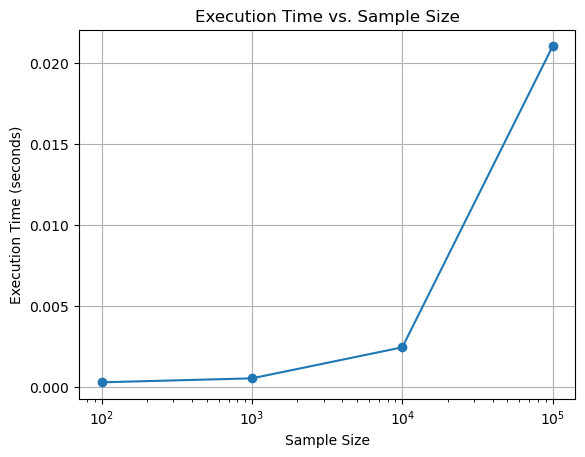

In [143]:
query_execution_graph(query_1)

### The Number of Businesses For Each Category

In [144]:
pd.read_sql_query(
    """
    WITH total_categories AS (
        SELECT UNNEST(categories) AS category
        FROM yelp_business
    ), num_categories AS (
        SELECT category, COUNT(category) AS num_category
        FROM total_categories
        GROUP BY category
        ORDER BY num_category DESC
    )

    SELECT * FROM num_categories LIMIT 20;
    """,
    conn_str
)

/var/folders/73/0ljy4_0j73jf5dbm29fbf7_m0000gn/T/ipykernel_97293/3267655940.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql_query(


,category,num_category
0,Restaurants,52268
1,Food,27781
2,Shopping,24395
3,Home Services,14356
4,Beauty & Spas,14292
5,Nightlife,12281
6,Health & Medical,11890
7,Local Services,11198
8,Bars,11065
9,Automotive,10773


### The Number of Unique Categories

In [145]:
pd.read_sql_query(
    """
    WITH total_categories AS (
    SELECT
        DISTINCT UNNEST(categories) AS category
    FROM yelp_business
    ), num_categories AS (
        SELECT
            COUNT(*)
        FROM total_categories
    )
    SELECT * FROM num_categories LIMIT 100;

    """,
    conn_str
)

/var/folders/73/0ljy4_0j73jf5dbm29fbf7_m0000gn/T/ipykernel_97293/4099918502.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql_query(


,count
0,1311


# Query 2: The Top Business in Every Yelp Category (1354)

### Top is calculated by highest star and the tie is broken by highest review count

In [146]:
pd.read_sql_query(
    """
    WITH parsed_categories AS (
    SELECT
        yb.business_id,
        yb.city,
        yb.state,
        yb.name,
        yb.stars,
        yb.review_count,
        UNNEST(yb.categories) AS category
    FROM yelp_business yb
    ),
    num_categories AS (
        SELECT DISTINCT
            category,
            COUNT(*) AS num_category
        FROM parsed_categories
        GROUP BY category
    ),
    ranked_businesses AS (
        SELECT
            pc.category,
            pc.business_id,
            pc.name,
            pc.city,
            pc.state,
            pc.stars,
            pc.review_count,
            nc.num_category,
            RANK() OVER (
                PARTITION BY pc.category
                ORDER BY pc.stars DESC, pc.review_count DESC
            ) AS rank_in_category
        FROM parsed_categories pc
        JOIN num_categories nc ON pc.category = nc.category
    )
    SELECT
        category,
        num_category,
        business_id,
        name,
        city,
        state,
        stars,
        review_count
    FROM ranked_businesses
    WHERE rank_in_category = 1
    ORDER BY num_category DESC
    LIMIT 10;
    """,
    conn_str
)

/var/folders/73/0ljy4_0j73jf5dbm29fbf7_m0000gn/T/ipykernel_97293/4080754582.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql_query(


,category,num_category,business_id,name,city,state,stars,review_count
0,Restaurants,52268,_aKr7POnacW_VizRKBpCiA,Blues City Deli,Saint Louis,MO,5.0,991
1,Food,27781,JbzvJJolDBT1614qo2Yiaw,Nelson's Green Brier Distillery,Nashville,TN,5.0,545
2,Shopping,24395,l_7TW_Ix58-QvhQgpJi_Xw,SUGARED + BRONZED,Philadelphia,PA,5.0,513
3,Home Services,14356,u3zqvp4BYUjzJD7tzx3Jbg,JB Plumbing and Heating,Philadelphia,PA,5.0,398
4,Beauty & Spas,14292,l_7TW_Ix58-QvhQgpJi_Xw,SUGARED + BRONZED,Philadelphia,PA,5.0,513
5,Nightlife,12281,_aKr7POnacW_VizRKBpCiA,Blues City Deli,Saint Louis,MO,5.0,991
6,Health & Medical,11890,hxZ-5CYuCbX_eb2vZbx20A,Royal Thai Massage,Santa Barbara,CA,5.0,241
7,Local Services,11198,eJUjeWndPCCqTjj0Jva-ug,Sterling Carpet Care,Reno,NV,5.0,276
8,Bars,11065,_aKr7POnacW_VizRKBpCiA,Blues City Deli,Saint Louis,MO,5.0,991
9,Automotive,10773,eJUjeWndPCCqTjj0Jva-ug,Sterling Carpet Care,Reno,NV,5.0,276


In [147]:
print(pd.read_sql_query(
    """
    EXPLAIN ANALYZE
    WITH parsed_categories AS (
    SELECT
        yb.business_id,
        yb.city,
        yb.state,
        yb.name,
        yb.stars,
        yb.review_count,
        UNNEST(yb.categories) AS category
    FROM yelp_business yb
    ),
    num_categories AS (
        SELECT DISTINCT
            category,
            COUNT(*) AS num_category
        FROM parsed_categories
        GROUP BY category
    ),
    ranked_businesses AS (
        SELECT
            pc.category,
            pc.business_id,
            pc.name,
            pc.city,
            pc.state,
            pc.stars,
            pc.review_count,
            nc.num_category,
            RANK() OVER (
                PARTITION BY pc.category
                ORDER BY pc.stars DESC, pc.review_count DESC
            ) AS rank_in_category
        FROM parsed_categories pc
        JOIN num_categories nc ON pc.category = nc.category
    )
    SELECT
        category,
        num_category,
        business_id,
        name,
        city,
        state,
        stars,
        review_count
    FROM ranked_businesses
    WHERE rank_in_category = 1
    ORDER BY num_category DESC
    LIMIT 10;
    """,
    conn_str
))

/var/folders/73/0ljy4_0j73jf5dbm29fbf7_m0000gn/T/ipykernel_97293/1550592036.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  print(pd.read_sql_query(


                                                                                                                                                                                      QUERY PLAN
0                                                                                          Limit  (cost=254394.04..254394.06 rows=10 width=220) (actual time=1560.524..1560.529 rows=10 loops=1)
1                                                                                                                                                                          CTE parsed_categories
2                                                                                     ->  ProjectSet  (cost=0.00..19421.97 rows=601384 width=96) (actual time=0.009..75.936 rows=668592 loops=1)
3                                                                  ->  Seq Scan on yelp_business yb  (cost=0.00..15287.46 rows=150346 width=162) (actual time=0.007..20.658 rows=150346 loops=1)
4                                  

In [148]:
def query_2(sample_size):
  query = f"""
    WITH parsed_categories AS (
    SELECT
        yb.business_id,
        yb.city,
        yb.state,
        yb.name,
        yb.stars,
        yb.review_count,
        UNNEST(yb.categories) AS category
    FROM yelp_business_{sample_size} yb
    ),
    num_categories AS (
        SELECT DISTINCT
            category,
            COUNT(*) AS num_category
        FROM parsed_categories
        GROUP BY category
    ),
    ranked_businesses AS (
        SELECT
            pc.category,
            pc.business_id,
            pc.name,
            pc.city,
            pc.state,
            pc.stars,
            pc.review_count,
            nc.num_category,
            RANK() OVER (
                PARTITION BY pc.category
                ORDER BY pc.stars DESC, pc.review_count DESC
            ) AS rank_in_category
        FROM parsed_categories pc
        JOIN num_categories nc ON pc.category = nc.category
    )
    SELECT
        category,
        num_category,
        business_id,
        name,
        city,
        state,
        stars,
        review_count
    FROM ranked_businesses
    WHERE rank_in_category = 1
    ORDER BY num_category DESC
    LIMIT 10;
    """
  return query

Running the query for sample size: 100
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Running the query for sample size: 1000
Execution time: 0.01 seconds
Execution time: 0.01 seconds
Execution time: 0.01 seconds
Execution time: 0.01 seconds
Execution time: 0.01 seconds
Execution time: 0.01 seconds
Execution time: 0.01 seconds
Execution time: 0.01 seconds
Execution time: 0.01 seconds
Execution time: 0.01 seconds
Running the query for sample size: 10000
Execution time: 0.09 seconds
Execution time: 0.09 seconds
Execution time: 0.09 seconds
Execution time: 0.09 seconds
Execution time: 0.09 seconds
Execution time: 0.09 seconds
Execution time: 0.08 seconds
Execution time: 0.08 seconds
Execution time: 0.09 seconds
Execution time: 0.09 seconds
Running th

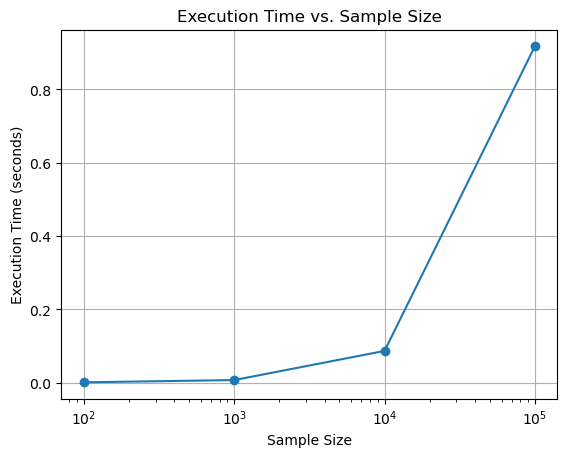

In [149]:
query_execution_graph(query_2)

# Query 3: What Month Do People Eat at Restaurants The Most?

In [150]:
pd.read_sql_query(
    """
    SELECT 
        TO_CHAR(ysr.date, 'Month') AS review_month,
        AVG(yb.stars) AS avg_stars,
        AVG(yb.review_count) AS avg_review_count,
        COUNT(ysr.review_id) AS total_reviews
    FROM yelp_business yb
    JOIN yelp_small_reviews ysr ON yb.business_id = ysr.business_id
    WHERE 'Restaurants' = ANY(yb.categories)
    GROUP BY review_month
    ORDER BY avg_review_count DESC
    """,
    conn_str
)

/var/folders/73/0ljy4_0j73jf5dbm29fbf7_m0000gn/T/ipykernel_97293/765948087.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql_query(


,review_month,avg_stars,avg_review_count,total_reviews


In [151]:
pd.read_sql_query(
    """
    EXPLAIN ANALYZE
    SELECT 
        TO_CHAR(ysr.date, 'Month') AS review_month,
        AVG(yb.stars) AS avg_stars,
        AVG(yb.review_count) AS avg_review_count,
        COUNT(ysr.review_id) AS total_reviews
    FROM yelp_business yb
    JOIN yelp_small_reviews ysr ON yb.business_id = ysr.business_id
    WHERE 'Restaurants' = ANY(yb.categories)
    GROUP BY review_month
    ORDER BY avg_review_count DESC
    """,
    conn_str
)

/var/folders/73/0ljy4_0j73jf5dbm29fbf7_m0000gn/T/ipykernel_97293/3697641227.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql_query(


,QUERY PLAN
0,Sort (cost=115037.72..115038.22 rows=200 width=104) (actual time=281.231..282.835 rows=0 loops=1)
1,Sort Key: (avg(yb.review_count)) DESC
2,Sort Method: quicksort Memory: 25kB
3,-> Finalize GroupAggregate (cost=114974.91..115030.08 rows=200 width=104) (actual time=281.221..282.825 rows=0 loops=1)
4,"Group Key: (to_char(ysr.date, 'Month'::text))"
5,-> Gather Merge (cost=114974.91..115021.58 rows=400 width=104) (actual time=281.221..282.824 rows=0 loops=1)
6,Workers Planned: 2
7,Workers Launched: 2
8,-> Sort (cost=113974.88..113975.38 rows=200 width=104) (actual time=275.905..275.907 rows=0 loops=3)
9,"Sort Key: (to_char(ysr.date, 'Month'::text))"


In [152]:
def query_3(sample_size):
  query = f"""
    SELECT 
        TO_CHAR(ysr.date, 'Month') AS review_month,
        AVG(yb.stars) AS avg_stars,
        AVG(yb.review_count) AS avg_review_count,
        COUNT(ysr.review_id) AS total_reviews
    FROM yelp_business_{sample_size} yb
    JOIN yelp_small_reviews ysr ON yb.business_id = ysr.business_id
    WHERE 'Restaurants' = ANY(yb.categories)
    GROUP BY review_month
    ORDER BY avg_review_count DESC
    """
  return query

Running the query for sample size: 100
Execution time: 0.26 seconds
Execution time: 0.54 seconds
Execution time: 0.27 seconds
Execution time: 0.19 seconds
Execution time: 0.18 seconds
Execution time: 0.18 seconds
Execution time: 0.16 seconds
Execution time: 0.17 seconds
Execution time: 0.18 seconds
Execution time: 0.17 seconds
Running the query for sample size: 1000
Execution time: 0.16 seconds
Execution time: 0.16 seconds
Execution time: 0.15 seconds
Execution time: 0.15 seconds
Execution time: 0.15 seconds
Execution time: 0.15 seconds
Execution time: 0.15 seconds
Execution time: 0.15 seconds
Execution time: 0.16 seconds
Execution time: 0.16 seconds
Running the query for sample size: 10000
Execution time: 0.15 seconds
Execution time: 0.16 seconds
Execution time: 0.17 seconds
Execution time: 0.17 seconds
Execution time: 0.16 seconds
Execution time: 0.18 seconds
Execution time: 0.15 seconds
Execution time: 0.15 seconds
Execution time: 0.16 seconds
Execution time: 0.16 seconds
Running th

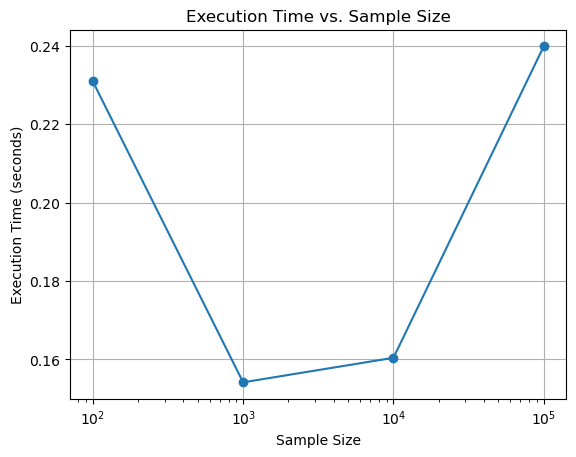

In [153]:
query_execution_graph(query_3)

# Query 4: Which User Has Most Friends

In [154]:
pd.read_sql_query(
    """
    SELECT 
        user_id, 
        name, 
        array_length(STRING_TO_ARRAY(friends, ','), 1) as number_of_friends
    FROM yelp_users
    ORDER BY number_of_friends DESC
    LIMIT 5;
    """,
    conn_str
)

/var/folders/73/0ljy4_0j73jf5dbm29fbf7_m0000gn/T/ipykernel_97293/820032490.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql_query(


,user_id,name,number_of_friends
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,14995
1,iLjMdZi0Tm7DQxX1C1_2dg,Ruggy,12395
2,ZIOCmdFaMIF56FR-nWr_2A,Randy,11026
3,mV4lknblF-zOKSF8nlGqDA,Scott,10366
4,Oi1qbcz2m2SnwUeztGYcnQ,Steven,10072


In [155]:
print(pd.read_sql_query(
    """
    EXPLAIN ANALYZE
    SELECT 
        user_id, 
        name, 
        array_length(STRING_TO_ARRAY(friends, ','), 1) as number_of_friends
    FROM yelp_users
    ORDER BY number_of_friends DESC
    LIMIT 5;
    """,
    conn_str
))

/var/folders/73/0ljy4_0j73jf5dbm29fbf7_m0000gn/T/ipykernel_97293/1646405005.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  print(pd.read_sql_query(


                                                                                                                                         QUERY PLAN
0                                                Limit  (cost=110193.43..110194.01 rows=5 width=33) (actual time=7338.376..7341.032 rows=5 loops=1)
1                               ->  Gather Merge  (cost=110193.43..303101.46 rows=1653382 width=33) (actual time=7338.375..7341.031 rows=5 loops=1)
2                                                                                                                                Workers Planned: 2
3                                                                                                                               Workers Launched: 2
4                                        ->  Sort  (cost=109193.40..111260.13 rows=826691 width=33) (actual time=7327.851..7327.851 rows=5 loops=3)
5                                                                             Sort Key: (array_length(string_to_

In [156]:
def query_4(sample_size):
  query = f"""
    SELECT 
        user_id, 
        name, 
        array_length(STRING_TO_ARRAY(friends, ','), 1) as number_of_friends
    FROM yelp_users_{sample_size}
    ORDER BY number_of_friends
    """
  return query

Running the query for sample size: 100
Execution time: 0.02 seconds
Execution time: 0.01 seconds
Execution time: 0.01 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Execution time: 0.00 seconds
Running the query for sample size: 1000
Execution time: 0.06 seconds
Execution time: 0.03 seconds
Execution time: 0.03 seconds
Execution time: 0.03 seconds
Execution time: 0.03 seconds
Execution time: 0.03 seconds
Execution time: 0.03 seconds
Execution time: 0.03 seconds
Execution time: 0.03 seconds
Execution time: 0.03 seconds
Running the query for sample size: 10000
Execution time: 0.34 seconds
Execution time: 0.15 seconds
Execution time: 0.16 seconds
Execution time: 0.15 seconds
Execution time: 0.15 seconds
Execution time: 0.15 seconds
Execution time: 0.15 seconds
Execution time: 0.15 seconds
Execution time: 0.15 seconds
Execution time: 0.15 seconds
Running th

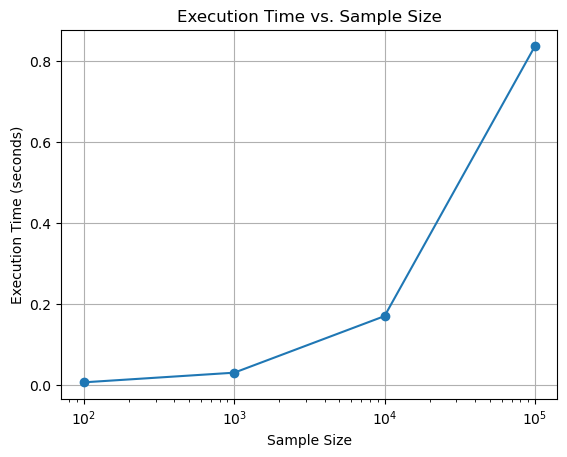

In [157]:
query_execution_graph(query_4)

# Query 5: Food Adventurer

In [158]:
pd.read_sql_query(
    """ 
    SELECT yu.user_id, yb.city, yb.state, COUNT(yb.business_id)
    FROM yelp_users yu
    JOIN yelp_small_reviews ysr ON yu.user_id = ysr.user_ids
    JOIN yelp_business yb ON ysr.business_id = yb.business_id
    GROUP BY yb.user_id, yb.city, yb.state
    """
)

TypeError: read_sql_query() missing 1 required positional argument: 'con'

# Query 6:

### NO INDEX

In [ ]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Do not wrap lines
pd.set_option('display.max_colwidth', None)  # Display all contents of each column
cursor.execute("DROP INDEX IF EXISTS business_city_idx;")
pd.read_sql_query(
    """ 
    SELECT yu.user_id, yu.name, AVG(yr.stars) AS avg_stars, yu.review_count
    FROM (SELECT * FROM yelp_business WHERE city = 'Philadelphia') yb
    JOIN yelp_small_reviews yr ON yb.business_id = yr.business_id
    JOIN yelp_users yu ON yu.user_id = yr.user_id
    GROUP BY yu.user_id, yu.name, yu.review_count
    ORDER BY avg_stars DESC, yu.review_count DESC
    LIMIT 10;
    """,
    conn_str
)

/var/folders/73/0ljy4_0j73jf5dbm29fbf7_m0000gn/T/ipykernel_2583/2403976294.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql_query(


,user_id,name,avg_stars,review_count
0,m07sy7eLtOjVdZ8oN9JKag,Ed,5.0,5800
1,syvwUKQJ4OYfmL_ixVLMeQ,Tina,5.0,4386
2,whINg-cC-FiAv_ATDGMDTg,PatrickJ,5.0,3775
3,uIBhZTxEdOw1FRVpSJ45mQ,Franklin,5.0,3683
4,gcMPEkEXekKN6mYhLUI-Rw,John,5.0,3148
5,zUKeZNu4tCG56xjwWH54Vw,Bill,5.0,2877
6,B7ecAeAIrXg7sgmabS38pg,Stephy,5.0,2605
7,kKTcYPz47sCDH1_ylnE4ZQ,Pegah,5.0,2595
8,Xxvz5g67eaCr3emnkY5M6w,Jen,5.0,2403
9,cJCYCEfDL4n5TgU9y8RTWg,Allister,5.0,2100


In [ ]:
print(pd.read_sql_query(
    """
    EXPLAIN ANALYZE
    SELECT yu.user_id, yu.name, AVG(yr.stars) AS avg_stars, yu.review_count
    FROM (SELECT * FROM yelp_business WHERE city = 'Philadelphia') yb
    JOIN yelp_small_reviews yr ON yb.business_id = yr.business_id
    JOIN yelp_users yu ON yu.user_id = yr.user_id
    GROUP BY yu.user_id, yu.name, yu.review_count
    ORDER BY avg_stars DESC, yu.review_count DESC
    LIMIT 10;
    """,
    conn_str
))

/var/folders/73/0ljy4_0j73jf5dbm29fbf7_m0000gn/T/ipykernel_2583/3411016360.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  print(pd.read_sql_query(


                                                                                                                                                                                 QUERY PLAN
0                                                                                      Limit  (cost=152590.35..152590.38 rows=10 width=65) (actual time=2172.680..2174.115 rows=10 loops=1)
1                                                                                ->  Sort  (cost=152590.35..152831.75 rows=96557 width=65) (actual time=2172.679..2174.114 rows=10 loops=1)
2                                                                                                                                      Sort Key: (avg(yr.stars)) DESC, yu.review_count DESC
3                                                                                                                                                 Sort Method: top-N heapsort  Memory: 26kB
4                                                          -

### INDEX


In [ ]:
cursor.execute("DROP INDEX IF EXISTS business_city_idx;")
cursor.execute("CREATE INDEX business_city_idx ON yelp_business(city);")

In [ ]:
print(pd.read_sql_query(
    """
    EXPLAIN ANALYZE
    SELECT yu.user_id, yu.name, AVG(yr.stars) AS avg_stars, yu.review_count
    FROM (SELECT * FROM yelp_business WHERE city = 'Philadelphia') yb
    JOIN yelp_small_reviews yr ON yb.business_id = yr.business_id
    JOIN yelp_users yu ON yu.user_id = yr.user_id
    GROUP BY yu.user_id, yu.name, yu.review_count
    ORDER BY avg_stars DESC, yu.review_count DESC
    LIMIT 10;
    """,
    conn_str
))

/var/folders/73/0ljy4_0j73jf5dbm29fbf7_m0000gn/T/ipykernel_2583/3411016360.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  print(pd.read_sql_query(


                                                                                                                                                                                 QUERY PLAN
0                                                                                      Limit  (cost=152590.35..152590.38 rows=10 width=65) (actual time=1278.996..1280.065 rows=10 loops=1)
1                                                                                ->  Sort  (cost=152590.35..152831.75 rows=96557 width=65) (actual time=1278.995..1280.063 rows=10 loops=1)
2                                                                                                                                      Sort Key: (avg(yr.stars)) DESC, yu.review_count DESC
3                                                                                                                                                 Sort Method: top-N heapsort  Memory: 26kB
4                                                          -

In [ ]:
import numpy as np
# Print graph

def query_execution_graph(query_function):
  # List of sample sizes (e.g., 100, 1000, 10000, etc.)
  sample_sizes = [10**i for i in range(2, 6)]

  # Dictionary to hold the execution times
  execution_times = {}

  # Establish a PostgreSQL connection
  conn = psycopg2.connect(
      dbname="yelp_database", user="postgres", password="postgres", host="localhost", port="5432"
  )
  cursor = conn.cursor()

  # Loop through each sample size, run the query, and record execution time
  for sample_size in sample_sizes:
        print(f"Running the query for sample size: {sample_size}")
        
        times = []
        for i in range(10):
            start_time = time.time()
            # Run the query for the given sample size
            query = query_function(sample_size)
            cursor.execute(query)
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"Execution time: {execution_time:.2f} seconds")
            times.append(execution_time)

        average_execution_time = np.mean(times)
        # Save the sample size and corresponding execution time into the dictionary
        execution_times[sample_size] = average_execution_time

  # Close the cursor and connection
  cursor.close()
  conn.close()

  # Print the execution times
  print(execution_times)

  # Plot the graph with execution times
  plot_graph_with_times(execution_times)

SyntaxError: invalid syntax (1296597280.py, line 22)